# Project 3
## Generative adversarial networks
### Generating of Faces digits with a GAN

First we import the modules we need

In [41]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets
from torchsummary import summary
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

Check that we're running on GPU, and initialize our device

In [6]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


Setup our MNIST dataloaders

In [65]:
class FFHQ_dataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = self.get_image_paths()
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = self.transform(image)
        return image

    def get_image_paths(self):
        image_paths = []
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    image_paths.append(os.path.join(root, file))
        return image_paths


In [54]:
data_path = './ffhq_dataset'

In [66]:
batch_size = 64
testset = FFHQ_dataset(f"{data_path}/test/")
trainset = FFHQ_dataset(f"{data_path}/train/")

test_loader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False, num_workers=1)
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=1)

Implement your **generator** network as a fully connected neural network.

You could start with a network that:
* takes as input a 100 long vector
* has four hidden layers with 2848 neurons
* uses LeakyReLU as the activation function
* uses BatchNorm
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [72]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fully_connected = nn.Sequential(
            nn.Linear(100, 128),
            nn.Linear(128, 8*8*256)
        )
        
        self.convolutional = nn.Sequential(
            #Printer(),

            nn.ConvTranspose2d(256, 128, 4, 2, padding=1),
            #Printer(),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            #Printer(),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(64, 32, 4, 2, padding=1),
            #Printer(),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 3, 3, 1, padding=1),
            #Printer(),
            nn.Tanh()
            
        )

    def forward(self, x):
        x = self.fully_connected(x)
        x = x.view(x.size(0), 256, 8, 8)
        x = self.convolutional(x)
        return x

Implement your **discriminator** network as a fully connected neural network

Start out with a network that
* takes as input an $28\times28$ image
* has three hidden layers with [1024, 512, 256] neurons respectively
* uses LeakyReLU as the activation function
* uses Dropout
* has no activation on the final layer (we will call sigmoid if we want a probability)

In [68]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fully_connected = nn.Sequential(
            nn.Linear(3*64*64, 6*16*16),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(6*16*16, 1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(256, 1),
            )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [58]:
smooth = 0.001
def discriminator_loss(x_true, x_fake, D):
    real_loss = torch.log(discriminator_final_layer(D(x_true)) + smooth).mean()
    fake_loss = torch.log(1-discriminator_final_layer(D(x_fake)) + smooth).mean()
    loss = - (real_loss + fake_loss)       
    return loss

def generator_loss(x_fake, D):
    loss = -torch.log(discriminator_final_layer(D(x_fake)) + smooth).mean()
    return loss

Now let's train our model

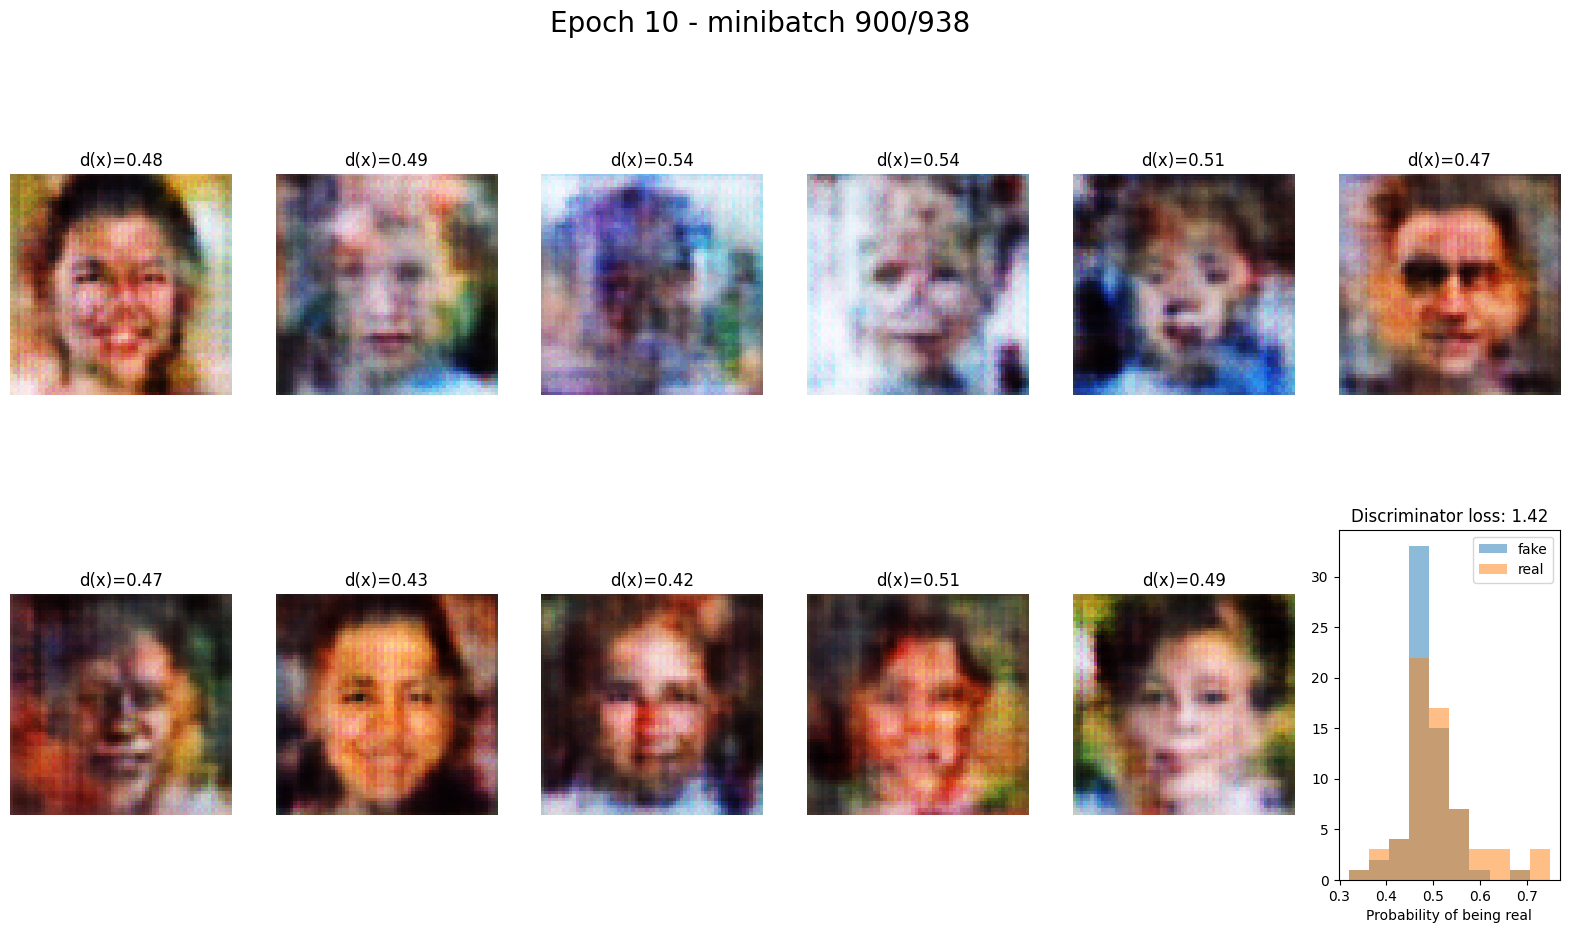

In [74]:
#Initialize networks
d = Discriminator().to(device)
g = Generator().to(device)
#summary(g, (64, 100))
d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
discriminator_final_layer = torch.sigmoid

for epoch in range(num_epochs):
    for minibatch_no, (x) in enumerate(train_loader):
        x_real = x.to(device)*2-1 #scale to (-1, 1) range
        z = torch.randn(x.shape[0], 100).to(device)
        x_fake = g(z)
        #Update discriminator
        d.zero_grad()
        #remember to detach x_fake before using it to compute the discriminator loss
        #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
        d_loss=discriminator_loss(x_real, x_fake.detach(), d)
        d_loss.backward()
        d_opt.step()

        #Update generator
        g.zero_grad()
        g_loss = generator_loss(x_fake, d)
        g_loss.backward()
        g_opt.step()

        assert(not np.isnan(d_loss.item()))
        #Plot results every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad():
                P = discriminator_final_layer(d(x_fake))
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(x_fake_k.permute(1, 2, 0) )
                    subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                z = torch.randn(batch_size, 100).to(device)
                H1 = discriminator_final_layer(d(g(z))).cpu()
                H2 = discriminator_final_layer(d(x_real)).cpu()
                plot_min = min(H1.min(), H2.min()).item()
                plot_max = max(H1.max(), H2.max()).item()
                subplots[-1].cla()
                subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].legend()
                subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())

                title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                plt.gcf().suptitle(title, fontsize=20)
                display.display(plt.gcf())
                display.clear_output(wait=True)

Do you get a model to generate nice images?

The plot shows probabilities of real and generated digits being classified as real. Is the discriminator able to distinguish real from fake? If not, try increasing the capacity of the discriminator.
Feel free to change the architecture as you see fit.

## Additional tasks
* Change the architecture to get better results
* Implement an LSGAN
* Implement a WGAN with SN
* Convert your network to a DCGAN
* Visualize what happens when you interpolate between to points in the latent space
* Generate images from FashionMNIST

### Harder tasks:
* Add data augmentation to fake and real images
* Use the data augmentation to the generated images
* Convert your architecture into an AC-GAN

## WGAN

In [ ]:
from torch.nn.utils.parametrizations import spectral_norm
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fully_connected = nn.Sequential(
            spectral_norm(nn.Linear(784, 2048)),
            nn.LeakyReLU(),
            nn.Dropout(),
            spectral_norm(nn.Linear(2048, 1024)),
            nn.LeakyReLU(),
            nn.Dropout(),
            spectral_norm(nn.Linear(1024, 512)),
            nn.LeakyReLU(),
            nn.Dropout(),
            spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(),
            nn.Dropout(),
            spectral_norm(nn.Linear(256, 1)),
            )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [ ]:
def w_critic_loss(x_true, x_fake, C):
    real_loss = - (C(x_true)).mean()
    fake_loss = (C(x_fake)).mean()
    loss = real_loss + fake_loss
    return loss

def w_generator_loss(x_fake, C):
    loss = - (C(x_fake)).mean()
    return loss

In [ ]:
#Initialize networks
d = Critic().to(device)
g2 = Generator().to(device)
d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10

for epoch in range(num_epochs):
    for minibatch_no, (x, target) in enumerate(train_loader):
        x_real = x.to(device)*2-1 #scale to (-1, 1) range
        z = torch.randn(x.shape[0], 100).to(device)
        x_fake = g(z)
        #Update critic
        d.zero_grad()
        d_loss = w_critic_loss(x_real, x_fake.detach(), d)
        d_loss.backward()
        d_opt.step()

        #Update generator
        g.zero_grad()
        g_loss = w_generator_loss(x_fake, d)
        g_loss.backward()
        g_opt.step()

        assert(not np.isnan(d_loss.item()))
        #Plot results every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad():
                P = discriminator_final_layer(d(x_fake))
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(x_fake_k, cmap='gray')
                    subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                z = torch.randn(batch_size, 100).to(device)
                H1 = discriminator_final_layer(d(g(z))).cpu()
                H2 = discriminator_final_layer(d(x_real)).cpu()
                plot_min = min(H1.min(), H2.min()).item()
                plot_max = max(H1.max(), H2.max()).item()
                subplots[-1].cla()
                subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].legend()
                subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())

                title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                plt.gcf().suptitle(title, fontsize=20)
                display.display(plt.gcf())
                display.clear_output(wait=True)


## Visualize interpolations 

In [ ]:
from numpy.lib.index_tricks import nd_grid
gen = g

# generate two random vectors
z0 = torch.randn(1, 100)
z1 = torch.randn(1, 100)
#z0 = torch.ones(1, 100)
#z1 = torch.zeros(1, 100)

# generate linear combinations
n = 11 # number of images in linear combination
r = torch.range(0,1,1/(n-1)).unsqueeze(1).float()
#z = torch.cat([z0, 0.25*z0+0.75*z1, 0.5*z0+0.5*z1, 0.75*z0+0.25*z1, z1])
z = torch.matmul(r,z0)+torch.matmul(r,z1)

#calculate network outputs
x_fake = gen(z.to(device))

# Plot
plt.figure(figsize=(20,5))
with torch.no_grad():
  P = discriminator_final_layer(d(x_fake))
  for k in range(n):
    x_fake_k = x_fake[k].cpu().squeeze()/2+.5
    plt.subplot(1, n, k+1)
    plt.imshow(x_fake_k, cmap='gray')
    plt.title('d(x)=%.2f' % P[k])
    plt.axis('off')

title = 'Linear interpolated random inputs'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
plt.gcf().suptitle(title, fontsize=20)